In [1]:
library('tidyverse')
library('ggrepel')
library('ggbeeswarm')
library('readxl')
library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
exp_matrix <-
    read_xlsx('counts raw chondrosarcoma.xlsx', sheet='TargetCountMatrix') %>%
    filter(!str_detect(`TargetName`, '^TR[ABDG][JVC][0-9]*'))

exp_matrix %>%
    head()

TargetName,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFC3,1.245731,1.741101,1.319508,1.148698,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.000000,1,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1,1.319508,1,1,1.000000,⋯,1.148698,2.605171,1.643752,1,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1,1.245731,1,1,1.000000,⋯,1.319508,4.324246,1.148698,1,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1,1.000000,1,1,1.000000,⋯,1.000000,2.701920,1.430969,1,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1,1.000000,1,1,1.148698,⋯,1.430969,4.042823,1.148698,1,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1,1.000000,1,1,1.000000,⋯,1.245731,3.758480,1.000000,1,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731


In [3]:
tumor_vs_peritumor <-
    read_xlsx('normalized raw chondrosarcoma.xlsx', sheet='TargetCountMatrix', n_max=1, col_names=paste('c', 1:141, sep='_')) %>%
    t()

tumor_vs_peritumor %>%
    head()

c_1,tumor
c_2,tumor
c_3,tumor
c_4,tumor
c_5,peritumor
c_6,peritumor


In [4]:
sample_annotations <-
    tibble(
        `sample_desc`=exp_matrix %>% select(-`TargetName`) %>% colnames(),
        `region_type`=tumor_vs_peritumor %>% as.vector()
    ) %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

sample_annotations %>%
    head()

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor


In [5]:
exp_tbl <-
    exp_matrix %>%
    pivot_longer(
        names_to='sample_desc',
        values_to='norm_exp',
        -`TargetName`
    ) %>%
    left_join(sample_annotations, by='sample_desc') %>%
    separate(`sample_desc`, c('sample_name', 'region_id', 'marker'), sep=' \\| ', remove=FALSE) %>%
    relocate(`region_type`, .after=`region_id`) %>%
    rename(`gene_symbol`=`TargetName`) %>%
    mutate(`marker`=case_when(
        `marker` == 'S100' ~ 'S100B',
        `marker` == 'DAPI' ~ 'S100B',
        TRUE ~ `marker`
    ))

exp_tbl %>%
    head()

gene_symbol,sample_desc,sample_name,region_id,region_type,marker,norm_exp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
RFC3,NMS23-471 | 001 | S100B,NMS23-471,001,tumor,S100B,1.245731
RFC3,NMS23-471 | 002 | S100B,NMS23-471,002,tumor,S100B,1.741101
RFC3,NMS23-471 | 003 | S100B,NMS23-471,003,tumor,S100B,1.319508
RFC3,NMS23-471 | 004 | S100B,NMS23-471,004,tumor,S100B,1.148698
RFC3,NMS23-471 | 005 | CD68,NMS23-471,005,peritumor,CD68,1.000000
RFC3,NMS23-471 | 005 | CD3,NMS23-471,005,peritumor,CD3,1.000000


In [6]:
samples_of_interest <-
    sample_annotations

samples_of_interest

sample_desc,sample_name,region_id,marker,region_type
<chr>,<chr>,<chr>,<chr>,<chr>
NMS23-471 | 001 | S100B,NMS23-471,001,S100B,tumor
NMS23-471 | 002 | S100B,NMS23-471,002,S100B,tumor
NMS23-471 | 003 | S100B,NMS23-471,003,S100B,tumor
NMS23-471 | 004 | S100B,NMS23-471,004,S100B,tumor
NMS23-471 | 005 | CD68,NMS23-471,005,CD68,peritumor
NMS23-471 | 005 | CD3,NMS23-471,005,CD3,peritumor
NMS23-471 | 006 | CD68,NMS23-471,006,CD68,peritumor
NMS23-471 | 006 | CD3,NMS23-471,006,CD3,peritumor
NMS23-471 | 007 | CD68,NMS23-471,007,CD68,peritumor


In [7]:
exp_matrix_dge <-
    exp_matrix %>%
    select(-`TargetName`) %>%
    select(all_of(samples_of_interest$`sample_desc`)) %>%
    as.matrix() %>%
    (function(x) {
        rownames(x) <- exp_matrix %>% select(`TargetName`) %>% pull
        
        x
    }) 

exp_matrix_dge

,NMS23-471 | 001 | S100B,NMS23-471 | 002 | S100B,NMS23-471 | 003 | S100B,NMS23-471 | 004 | S100B,NMS23-471 | 005 | CD68,NMS23-471 | 005 | CD3,NMS23-471 | 006 | CD68,NMS23-471 | 006 | CD3,NMS23-471 | 007 | CD68,NMS23-471 | 007 | CD3,⋯,S10-479 | 013 | CD3,S10-479 | 013 | S100,S10-479 | 014 | CD68,S10-479 | 014 | CD3,S10-479 | 014 | S100,S10-479 | 015 | CD68,S10-479 | 015 | CD3,S10-479 | 015 | S100,S10-479 | 016 | CD68,S10-479 | 016 | CD3
RFC3,1.245731,1.741101,1.319508,1.148698,1.000000,1.000000,1.000000,1.000000,1.000000,1.148698,⋯,1.000000,2.701920,1.000000,1.000000,1.245731,1.319508,1.245731,1.000000,1.430969,1.888175
PSMB5,2.047673,1.148698,1.888175,1.245731,1.000000,1.319508,1.000000,1.000000,1.000000,1.515717,⋯,1.148698,2.605171,1.643752,1.000000,1.430969,1.000000,1.000000,1.430969,1.643752,1.148698
POLD4,1.741101,1.000000,1.430969,1.515717,1.000000,1.245731,1.000000,1.000000,1.000000,1.430969,⋯,1.319508,4.324246,1.148698,1.000000,1.782602,1.319508,1.319508,1.000000,1.430969,1.245731
MAP3K8,1.430969,1.245731,1.430969,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.515717,⋯,1.000000,2.701920,1.430969,1.000000,2.111786,1.319508,1.000000,1.430969,1.319508,1.000000
IRF9,1.515717,1.148698,1.888175,1.148698,1.000000,1.000000,1.000000,1.000000,1.148698,1.319508,⋯,1.430969,4.042823,1.148698,1.000000,1.741101,1.148698,1.148698,1.430969,1.000000,1.430969
PAX3,1.643752,1.148698,1.000000,1.515717,1.000000,1.000000,1.000000,1.000000,1.000000,1.319508,⋯,1.245731,3.758480,1.000000,1.000000,2.352158,1.000000,1.148698,1.148698,1.148698,1.245731
APOB,1.000000,1.430969,2.141127,1.000000,1.000000,1.148698,1.000000,1.000000,1.000000,1.148698,⋯,1.000000,4.919019,1.319508,1.000000,1.741101,1.000000,1.319508,1.245731,1.000000,1.319508
RASGRP2,1.782602,1.000000,1.643752,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.245731,⋯,1.000000,4.816449,1.245731,1.000000,1.888175,1.430969,1.148698,1.000000,1.245731,1.430969
JAK2,1.551846,1.148698,1.515717,1.551846,1.000000,1.000000,1.000000,1.148698,1.000000,1.515717,⋯,1.319508,5.552989,1.245731,1.245731,1.319508,1.551846,1.000000,1.148698,1.000000,1.515717
PLA2G4E,1.000000,1.000000,1.000000,1.245731,1.000000,1.000000,1.000000,1.000000,1.000000,1.319508,⋯,1.245731,3.365865,1.148698,1.000000,1.974350,1.000000,1.148698,1.000000,1.148698,1.515717


In [8]:
exp_model <-
    samples_of_interest %>%
    model.matrix(data=., ~0+`sample_name`+`region_type`)

exp_model

,sample_nameNMS22-289343,sample_nameNMS23-471,sample_nameS08-25548,sample_nameS10-479,region_typetumor
1,0,1,0,0,1
2,0,1,0,0,1
3,0,1,0,0,1
4,0,1,0,0,1
5,0,1,0,0,0
6,0,1,0,0,0
7,0,1,0,0,0
8,0,1,0,0,0
9,0,1,0,0,0
10,0,1,0,0,0


In [9]:
dge <-
    DGEList(exp_matrix_dge) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model, min.count=.1)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [10]:
colnames(all_fit$coefficients)

[1] "sample_nameNMS22-289343" "sample_nameNMS23-471"   
[3] "sample_nameS08-25548"    "sample_nameS10-479"     
[5] "region_typetumor"

In [11]:
all_table <-
    topTable(all_fit, adjust.method='fdr', coef=5, n=nrow(exp_matrix_dge), sort.by='p') %>%
    rownames_to_column(var='gene') %>%
    as_tibble()

all_table %>%
    head(50)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL11A2,0.3069714,9.567516,5.731408,5.278202e-08,9.585215e-05,8.0949847
HLA-C,-0.3363600,9.364016,-5.380338,2.794990e-07,2.537851e-04,6.5293790
PBX1,-0.2123612,9.484647,-5.017710,1.458904e-06,8.528764e-04,5.0033948
PSAT1,-0.2035720,9.493339,-4.948023,1.987241e-06,8.528764e-04,4.7182204
LGALS3,-0.1938945,9.447887,-4.910121,2.348228e-06,8.528764e-04,4.5652931
MAPK11,-0.1990749,9.538956,-4.823964,3.421039e-06,1.035434e-03,4.2194253
SOST,-0.2021504,9.473723,-4.692254,6.029209e-06,1.361396e-03,3.6985362
FANCE,-0.1953180,9.488462,-4.656448,7.020607e-06,1.361396e-03,3.5592088
PIK3CD,-0.2073656,9.522073,-4.625698,7.996189e-06,1.361396e-03,3.4374695


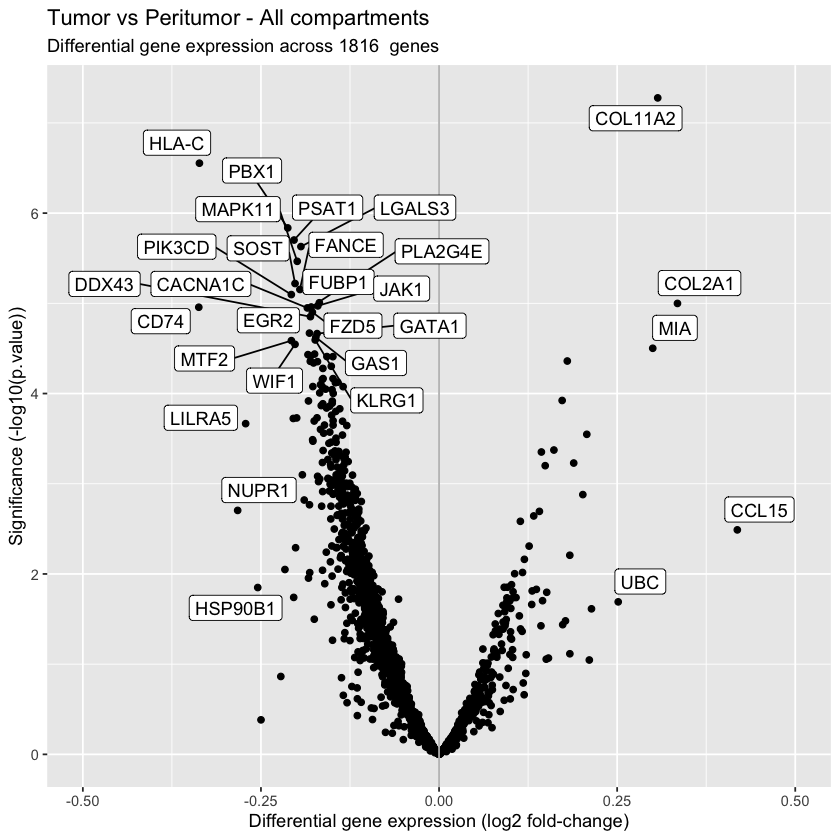

In [12]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 0.25 ~ str_replace_all(`gene`, ',.*', ''),
            -log10(`P.Value`) > 4.5 ~ str_replace_all(`gene`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes')
        ) +
        xlim(-0.5, 0.5)


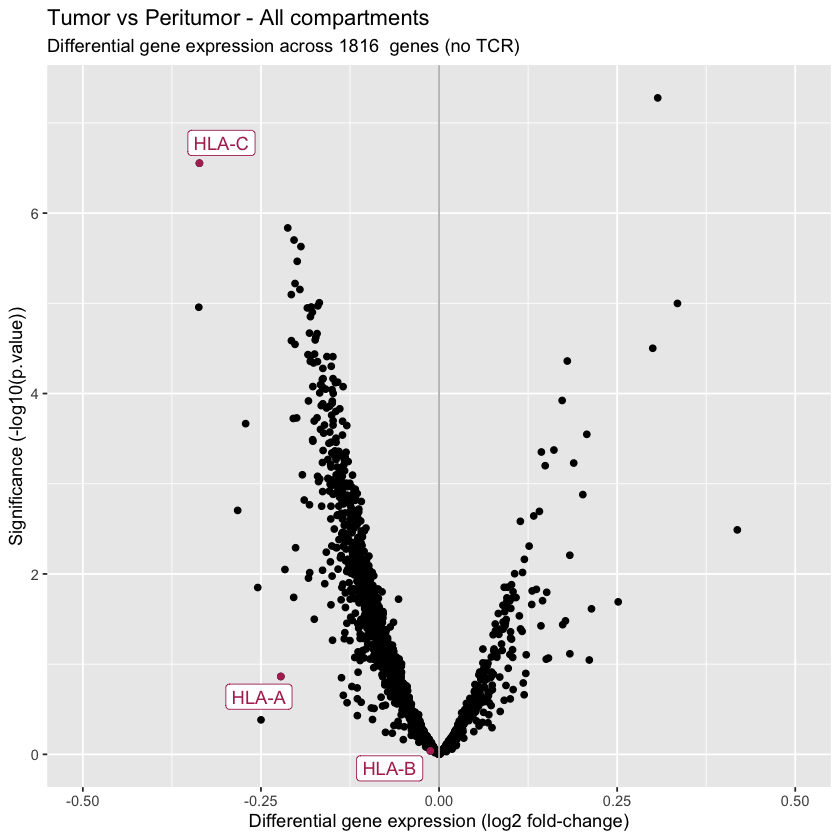

In [13]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('HLA-A', 'HLA-B', 'HLA-C') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


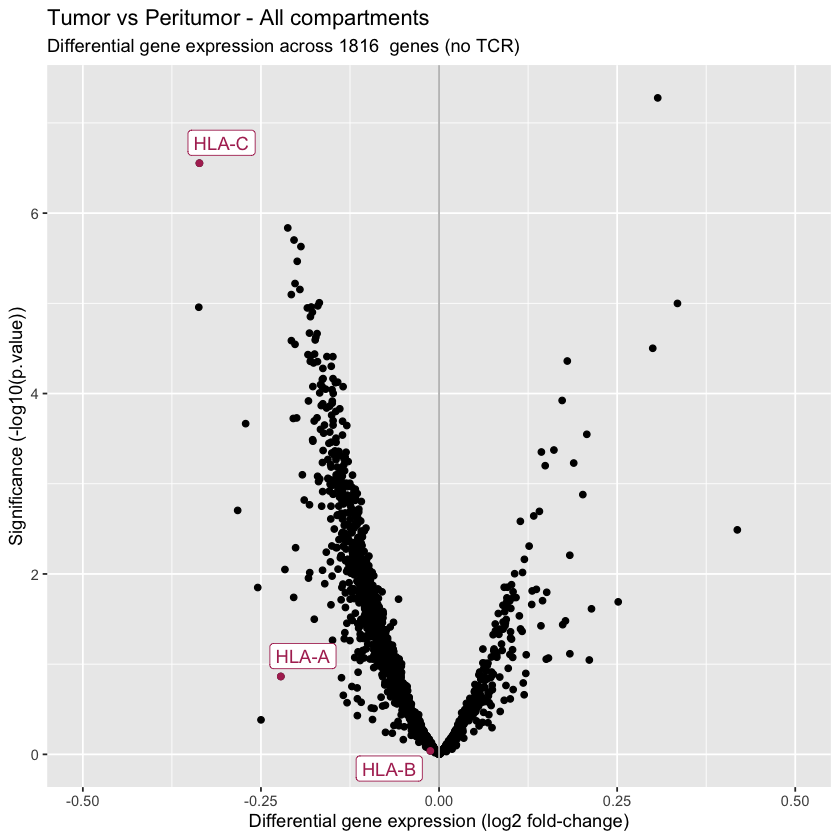

In [14]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('HLA-A', 'HLA-B', 'HLA-C') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


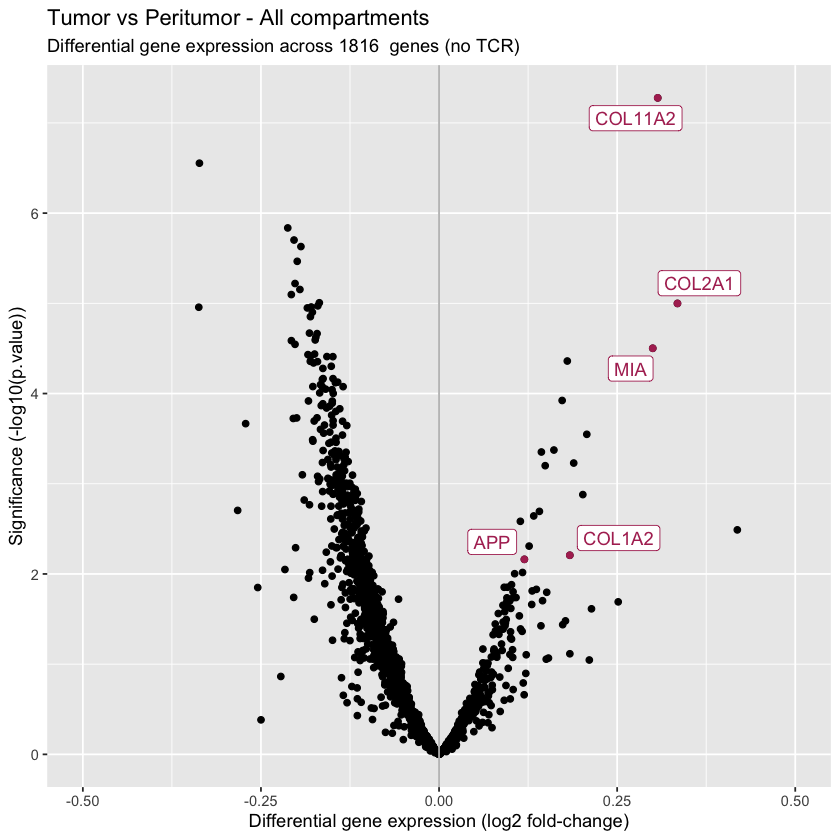

In [15]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('COL2A1', 'COL11A2', 'MIA', 'COL1A2', 'APP') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


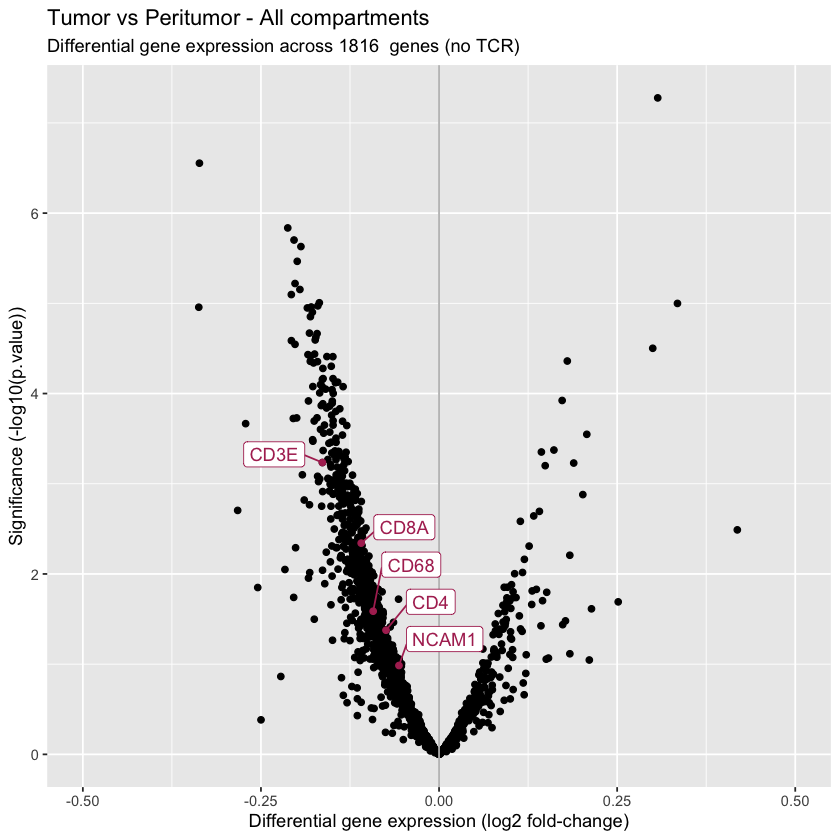

In [16]:
all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% c('CD8A', 'CD4', 'CD3E', 'CD68', 'NCAM1') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


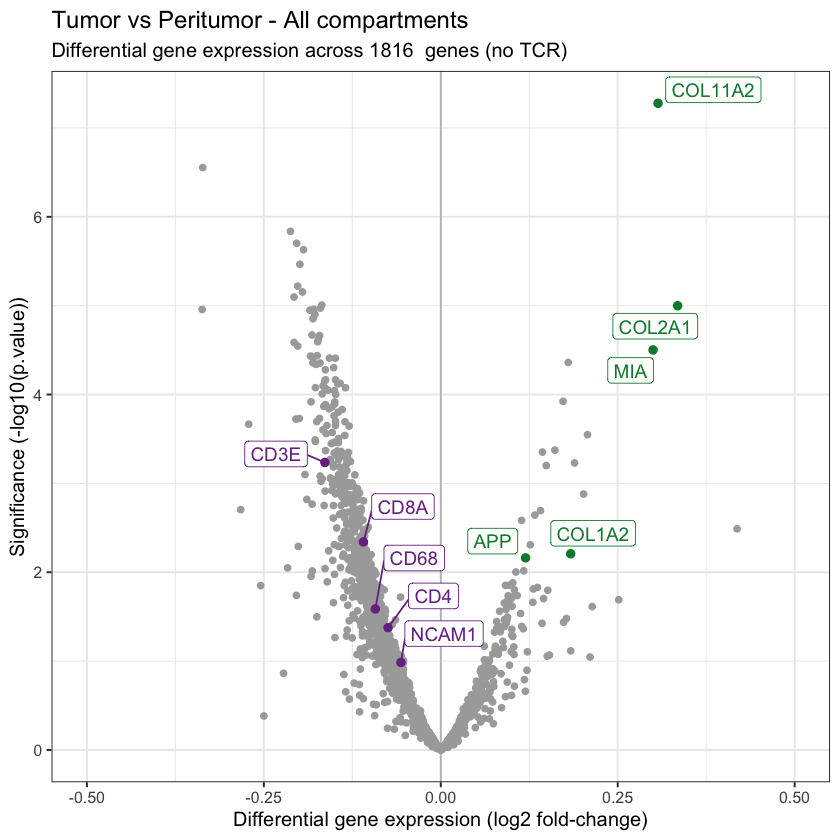

In [17]:
dge_figure <-
    all_table %>%
    mutate(
        `im_label`=case_when(
            `gene` %in% c('CD8A', 'CD4', 'CD3E', 'CD68', 'NCAM1') ~ `gene`,
            TRUE ~ ''
        ),
        `sarc_label`=case_when(
            `gene` %in% c('COL2A1', 'COL11A2', 'MIA', 'COL1A2', 'APP') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_vline(xintercept=0, color='gray') +
        geom_point(color='darkgray') +

        geom_point(data=. %>% filter(`im_label` != ''), color='#7b3294', size=2) +
        geom_label_repel(aes(label=`im_label`), max.overlaps=Inf, color='#7b3294', size=4) +

        geom_point(data=. %>% filter(`sarc_label` != ''), color='#008837', size=2) +
        geom_label_repel(aes(label=`sarc_label`), max.overlaps=Inf, color='#008837', size=4) +

        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
    
        theme_bw(base_size=12) +

        xlim(-0.5, 0.5)

dge_figure

In [18]:
ggsave(dge_figure, filename='Sarcoma-Tumor_vs_peritumor.svg')

Saving 7 x 7 in image


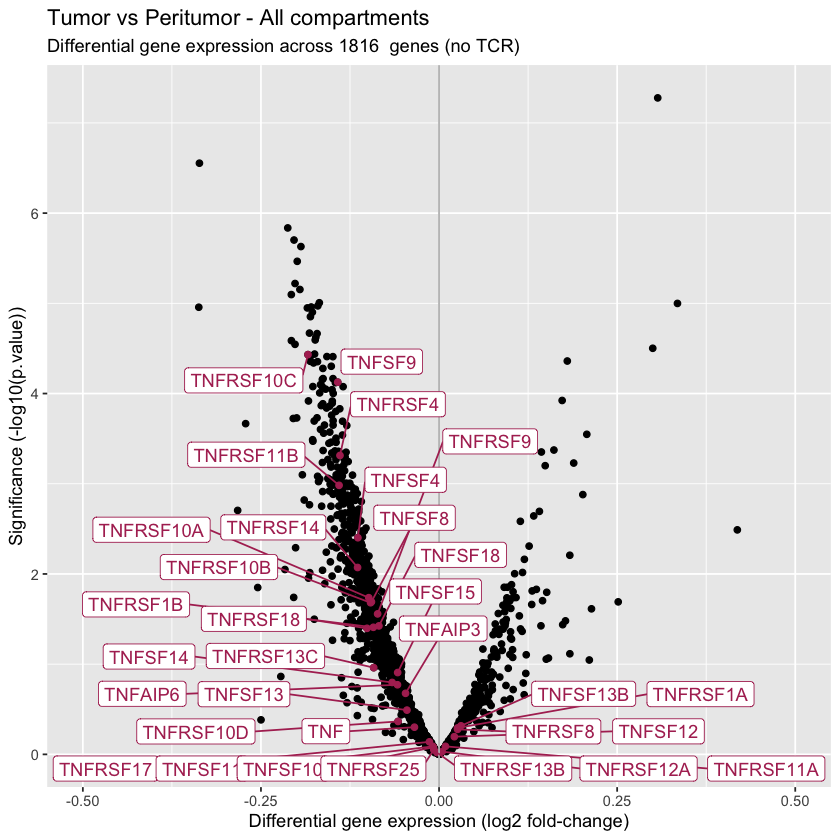

In [19]:
all_table %>%
    mutate(
        `label`=case_when(
            startsWith(`gene`, 'TNF') ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


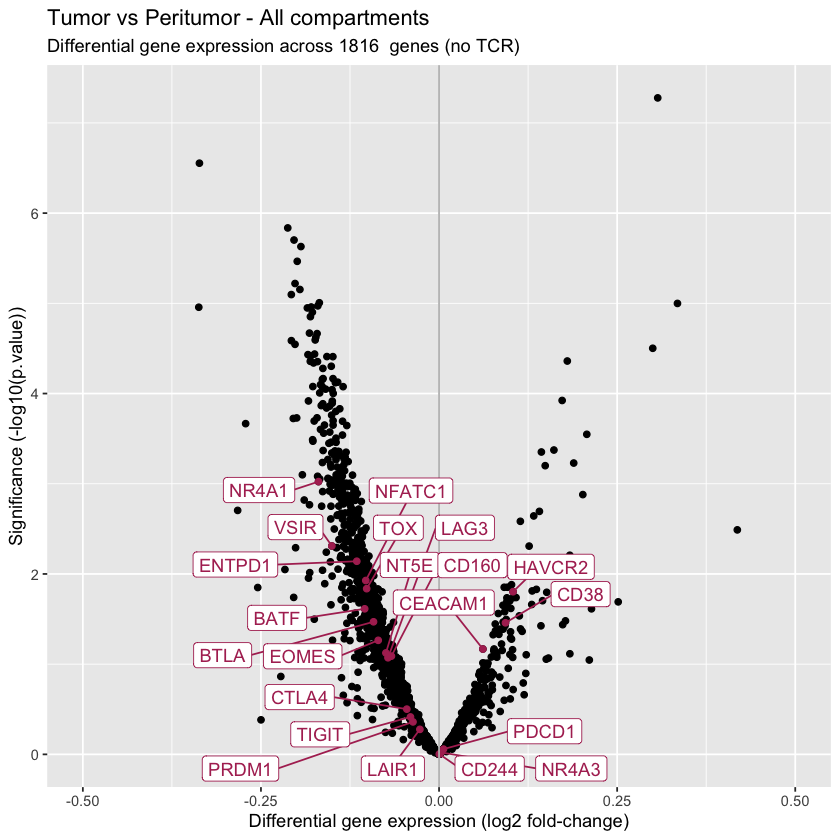

In [24]:
ex_markers <- c("PDCD1", "CTLA4", "HAVCR2", "LAG3", "TIGIT", "CD244", "CD160", "BTLA", "VSIR", "CEACAM1", "LAIR1", "SIGLEC7", "SIGLEC9", "ENTPD1", "NT5E", "CD38", "TOX", "TOX2", "NR4A1", "NR4A2", "NR4A3", "BATF", "EOMES", "PRDM1", "NFATC1")


all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% ex_markers ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


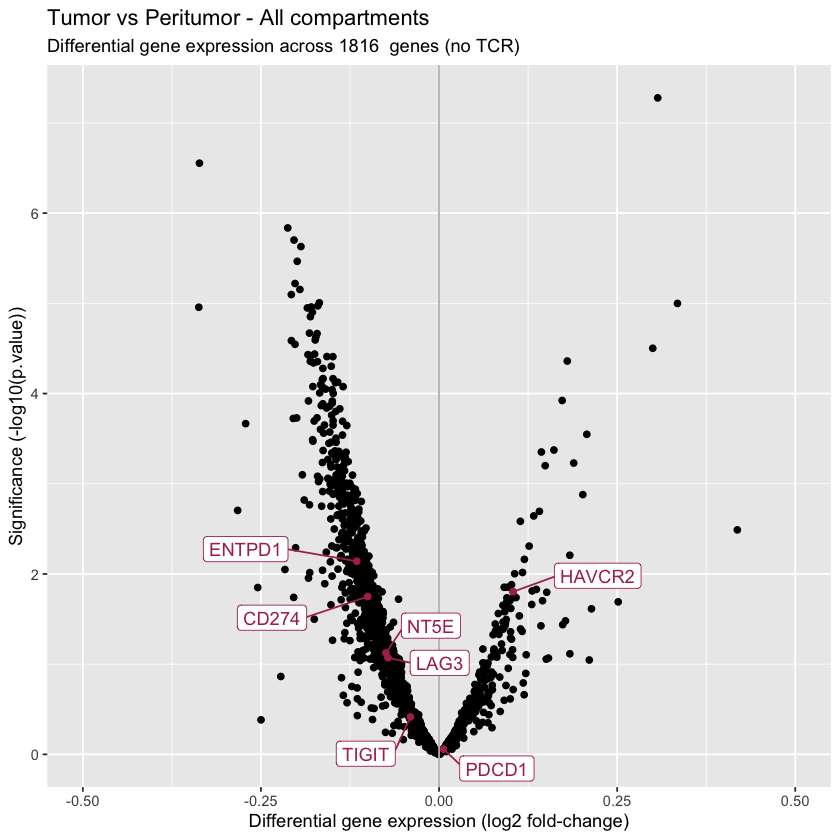

In [27]:
strict_surface <- c("PDCD1","HAVCR2","LAG3","TIGIT","ENTPD1", "CD274")

all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% strict_surface ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


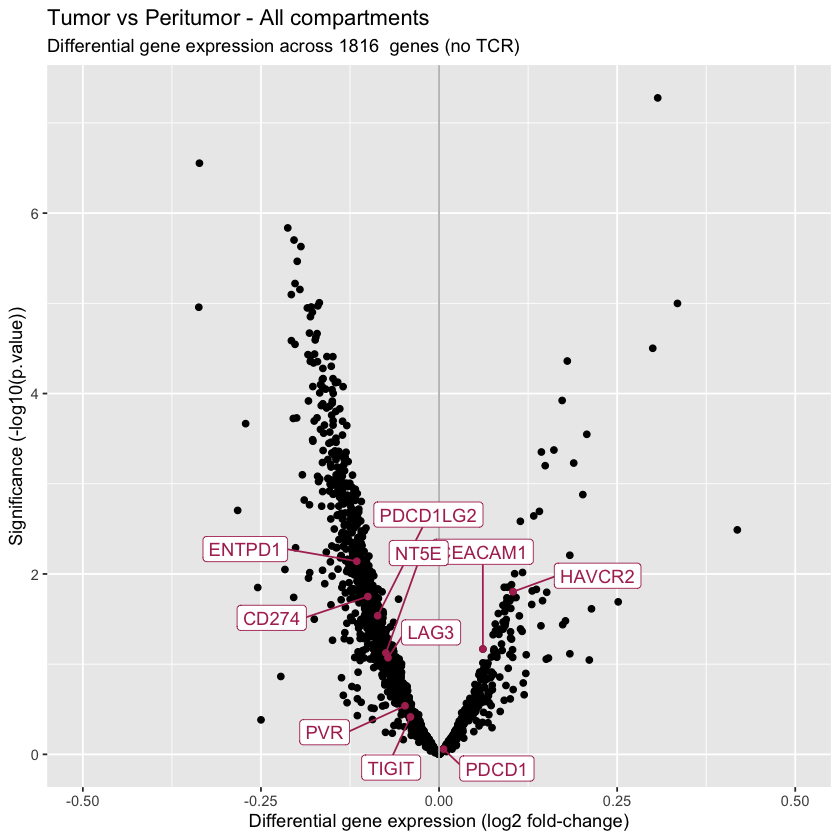

In [37]:
combos_surface <- c(
    "HAVCR2", "CEACAM1",
    "PDCD1", "CD274", "PDCD1LG2",
    "LAG3",
    "TIGIT", "PVR", "PVRL2",
    "ENTPD1", "NT5E"
)

all_table %>%
    mutate(
        `label`=case_when(
            `gene` %in% combos_surface ~ `gene`,
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_point(data=. %>% filter(`label` != ''), color='maroon') +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, color='maroon') +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='Tumor vs Peritumor - All compartments',
            subtitle=paste('Differential gene expression across', nrow(all_table), ' genes (no TCR)')
        ) +
        xlim(-0.5, 0.5)


In [20]:
all_table %>%
    write_csv('geomx-dge-tumor_vs_peritumor-without_tcrs-cleaned.csv')

In [21]:
all_table %>%
    filter(`logFC` < 0, `adj.P.Val` < 0.05) %>%
    head(50)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HLA-C,-0.3363600,9.364016,-5.380338,2.794990e-07,0.0002537851,6.5293790
PBX1,-0.2123612,9.484647,-5.017710,1.458904e-06,0.0008528764,5.0033948
PSAT1,-0.2035720,9.493339,-4.948023,1.987241e-06,0.0008528764,4.7182204
LGALS3,-0.1938945,9.447887,-4.910121,2.348228e-06,0.0008528764,4.5652931
MAPK11,-0.1990749,9.538956,-4.823964,3.421039e-06,0.0010354343,4.2194253
SOST,-0.2021504,9.473723,-4.692254,6.029209e-06,0.0013613965,3.6985362
FANCE,-0.1953180,9.488462,-4.656448,7.020607e-06,0.0013613965,3.5592088
PIK3CD,-0.2073656,9.522073,-4.625698,7.996189e-06,0.0013613965,3.4374695
FUBP1,-0.1680490,9.513829,-4.576072,9.852458e-06,0.0013613965,3.2471203


In [22]:
all_table %>%
    filter(`logFC` > 0, `adj.P.Val` < 0.1) %>%
    head(50)

gene,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
COL11A2,0.30697138,9.567516,5.731408,5.278202e-08,9.585215e-05,8.0949847
COL2A1,0.33466386,9.605272,4.571971,1.002321e-05,1.361396e-03,3.2281579
MIA,0.29996949,9.760626,4.292778,3.149325e-05,2.382990e-03,2.1865258
HSD17B8,0.18001627,9.566479,4.211154,4.359816e-05,2.513191e-03,1.8762319
CUL1,0.17279267,9.532145,3.951027,1.193468e-04,4.317544e-03,0.9566093
NDUFA13,0.20740778,9.634239,3.717765,2.831028e-04,7.042668e-03,0.1838747
IL11RA,0.16122879,9.709336,3.605736,4.228873e-04,9.206709e-03,-0.1918334
CYP8B1,0.14364630,9.566822,3.591529,4.446812e-04,9.206709e-03,-0.2379450
CIC,0.18904023,9.572280,3.511032,5.895495e-04,1.081436e-02,-0.4867413


In [23]:
all_table %>%
    filter(`logFC` > 0, `adj.P.Val` < 0.05) %>%
    head(50) %>%
    select(`gene`, `logFC`, `adj.P.Val`)

gene,logFC,adj.P.Val
<chr>,<dbl>,<dbl>
COL11A2,0.3069714,9.585215e-05
COL2A1,0.3346639,1.361396e-03
MIA,0.2999695,2.382990e-03
HSD17B8,0.1800163,2.513191e-03
CUL1,0.1727927,4.317544e-03
NDUFA13,0.2074078,7.042668e-03
IL11RA,0.1612288,9.206709e-03
CYP8B1,0.1436463,9.206709e-03
CIC,0.1890402,1.081436e-02
